# Инфраструктура Python. Веб

Концепция веба строится на выдаче программой веб-сервером на одном компьютере через Интернет по протоколу HTTP группы запрошенных по URL файлов программе браузеру на другом компьютере. Эта файлы (преимущественно веб-страница в формате HTML, таблицы стилей на языке CSS, программы управления содержимым веб-страницы на языке JavaScript, картинки (JPG, PNG и другие)) отображаются браузером конечному пользователю, который, взаимодействуя с показанной веб-страницей, может вызывать последующие запросы к тому же или иному веб-серверу.

Клиентские языки, такие как HTML, CSS, JavaScript, SVG, выходят за рамки этого гайда.

На скриншоте ниже изображен сниффер Wireshark https://www.wireshark.org/ , основная утилита для отладки сетевых протоколов. В главном окне указаны 7 TCP/IP пакетов, которыми обмениваются компьютер-клиент и сервер `ip-api.com` при запросе к http://ip-api.com/json (его IP-адрес получается отдельным запросом к серверам DNS). В окне поверх отображаются передаваемые в сетевом обмене по протоколу HTTP данные, красным отправляемые клиентом, синим полученные. Ваш город и координаты могут отличаться.

In [1]:
import IPython

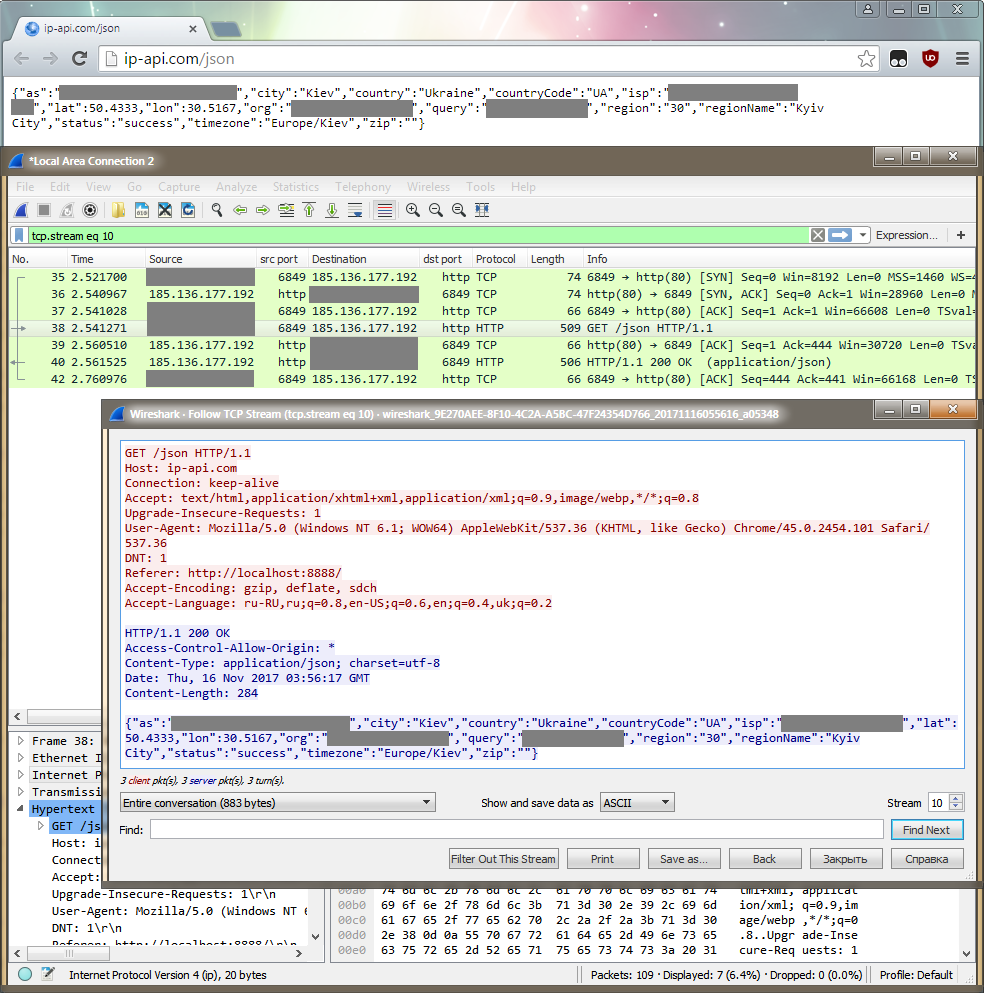

In [51]:
IPython.display.Image('wireshark.png')

## Веб-клиент

Упоминаются библиотеки `requests`, `pysocks`, `win_inet_pton`, `retrying`.

Наиболее удобным способом делать запросы в веб из Python является библиотека `requests`, входящая в состав Anaconda.

In [1]:
import requests, json

In [15]:
requests.get('http://packet.city').content

'<title>best TCP packet</title><link id=l href= rel=icon><pre id=p></pre><img id=z>YOUR_120_BYTE_AD_HERE<img id=y><script>c=new AudioContext;n=setInterval("for(n+=7,i=k,P=\'\\u25b2.\\\\n\';i-=1/k;P+=P[i%2?(i%2*j-j+n/k^j)&1:2])j=k/i;p.innerHTML=P;with(c.createOscillator())frequency.value=200*(j+n/k^j),connect(c.destination),start(),stop(n/k)",k=64);z.src=y.src=l.href</script>'

In [7]:
resp = requests.get('http://ip-api.com/json')
print resp
print resp.status_code
print resp.elapsed
print resp.headers
result = resp.json()
print result['city'], result['country']

<Response [200]>
200
0:00:00.045000
{'Date': 'Thu, 16 Nov 2017 04:32:59 GMT', 'Access-Control-Allow-Origin': '*', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '284'}
Kiev Ukraine


Библиотека `requests` позволяет достаточно гибко настраивать запрос, например, передавать его через локальный TOR-прокси. Протокол `socks5h://` указывает, что DNS запросы тоже надо делать через прокси.

```
requests 2.10.0+
pysocks
под виндой дополнительно поставить и импортнуть манки-патч win_inet_pton
```

In [47]:
'доступ до цього ресурсу заблоковано' in requests.get('http://ya.ru').content

True

In [48]:
import win_inet_pton
proxies = {'http': 'socks5h://127.0.0.1:9050', 'https': 'socks5h://127.0.0.1:9050'}

In [50]:
result = requests.get('http://ip-api.com/json', proxies=proxies).json()
print result['city'], result['country']

Roosendaal Netherlands


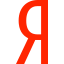

In [45]:
from lxml import etree
from PIL import Image
import io

resp = requests.get('http://ya.ru', proxies=proxies)
html = resp.content
url = 'http:' + etree.HTML(html).xpath('//link[@rel="shortcut icon"]/@href')[0]
icon = requests.get(url, proxies=proxies).content
Image.open(io.BytesIO(icon))

Помимо `requests.get` есть `requests.post` итп. Именоваными параметрами в них можно передать `headers`, `cookies`, в `.get`  `params`, в `.post` `data` или `files` (вида `{'file_key': ('filename', 'content')}`)

Куки, выставленные сервером, можно сохранять в объекте типа `RequestsCookieJar`, если пользоваться контекстом `request.Session()` для запросов.

In [59]:
with requests.Session() as session:
    resp = session.get('http://ya.ru', proxies=proxies)
    print session.cookies.get_dict()

{'i': '+xGVCFUuTaDOrhPXdH3uc3Tjphg/rDMGL30CkH55zIsog4TO3YULQfUhsWrKQ+ec4vigCwHivVnXO63M4M/7ltNVO+M=', 'yp': '1513407450.ygu.1', 'yandexuid': '7245764721510815448', 'mda': '0', 'yandex_gid': '143'}


При работе с вебом из-за загрузки или глюков сервера может понадобиться повторять операцию получения данных несколько раз, до успеха, возможно, выдержав паузу. Эти стратегии реализованы в библиотеке `retrying`.

```
pip install retrying
```

In [4]:
from retrying import retry
import sys, random
from time import time

In [13]:
t0 = time()

#@retry(wait_fixed=200, stop_max_attempt_number=50)
@retry(wait_exponential_multiplier=200, stop_max_delay=20000)
def do_something_unreliable():
    global t0
    x = random.randint(0, 10)
    print '%.3f s since last call, rnd=%d' % (time() - t0, x); sys.stdout.flush()
    t0 = time()
    if x > 1:
        raise Exception('failure')
    else:
        return 'Success!'

random.seed(2)
print do_something_unreliable()

0.001 s since last call, rnd=10
0.400 s since last call, rnd=10
0.800 s since last call, rnd=0
Success!


## Кодирование данных в веб

При работе с вебом приходится собирать-разбирать URL и преобразовывать специфические способы кодировки. Библиотеки `urllib`, `urlparse`, `HTMLParser`, `cgi` входят в состав Python.

In [49]:
import urllib, urlparse
print urllib.unquote_plus('%7E%20%25')
print urllib.quote_plus('~ %')
print urllib.urlencode({'param1': 'Привет', 'param2': 'def ghi'})
print urlparse.parse_qs('param2=def+ghi&param1=%D0%9F%D1%80%D0%B8%D0%B2%D0%B5%D1%82')
print
print urlparse.urlparse('http://www.example.com:8080/~user/file.html?data=wat#toc')
print repr(urlparse.urlunparse(('https', 'example.com', '/search', None, 'a=&b=', 'toc')))
print repr(urlparse.urljoin('https://server.com/folder/folder2/inside.html', '../file.html'))

~ %
%7E+%25
param2=def+ghi&param1=%D0%9F%D1%80%D0%B8%D0%B2%D0%B5%D1%82
{'param2': ['def ghi'], 'param1': ['\xd0\x9f\xd1\x80\xd0\xb8\xd0\xb2\xd0\xb5\xd1\x82']}

ParseResult(scheme='http', netloc='www.example.com:8080', path='/~user/file.html', params='', query='data=wat', fragment='toc')
'https://example.com/search?a=&b=#toc'
'https://server.com/folder/file.html'


In [30]:
from HTMLParser import HTMLParser
print HTMLParser().unescape('&mdash;')
print [k for k, v in HTMLParser.entitydefs.items() if v in u'♥♣♦♠']
print ' '.join([v for k, v in sorted(HTMLParser().entitydefs.items(), key=lambda (k,v): v)])

—
['clubs', 'spades', 'diams', 'hearts']
" & ' < >   ¡ ¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ­ ® ¯ ° ± ² ³ ´ µ ¶ · ¸ ¹ º » ¼ ½ ¾ ¿ À Á Â Ã Ä Å Æ Ç È É Ê Ë Ì Í Î Ï Ð Ñ Ò Ó Ô Õ Ö × Ø Ù Ú Û Ü Ý Þ ß à á â ã ä å æ ç è é ê ë ì í î ï ð ñ ò ó ô õ ö ÷ ø ù ú û ü ý þ ÿ Œ œ Š š Ÿ ƒ ˆ ˜ Α Β Γ Δ Ε Ζ Η Θ Ι Κ Λ Μ Ν Ξ Ο Π Ρ Σ Τ Υ Φ Χ Ψ Ω α β γ δ ε ζ η θ ι κ λ μ ν ξ ο π ρ ς σ τ υ φ χ ψ ω ϑ ϒ ϖ       ‌ ‍ ‎ ‏ – — ‘ ’ ‚ “ ” „ † ‡ • … ‰ ′ ″ ‹ › ‾ ⁄ € ℑ ℘ ℜ ™ ℵ ← ↑ → ↓ ↔ ↵ ⇐ ⇑ ⇒ ⇓ ⇔ ∀ ∂ ∃ ∅ ∇ ∈ ∉ ∋ ∏ ∑ − ∗ √ ∝ ∞ ∠ ∧ ∨ ∩ ∪ ∫ ∴ ∼ ≅ ≈ ≠ ≡ ≤ ≥ ⊂ ⊃ ⊄ ⊆ ⊇ ⊕ ⊗ ⊥ ⋅ ⌈ ⌉ ⌊ ⌋ 〈 〉 ◊ ♠ ♣ ♥ ♦


Выводя пользовательскую строку в браузер, нужно обязательно эскейпить символы HTML, чтобы избежать XSS, вставки произвольного кода, который будет исполнен в браузере пользователя. Для этого можно использовать стандартную библиотеку `cgi`.

In [17]:
import cgi
print cgi.escape('<b class="a">123</b>', True)
print cgi.escape('<b class="a">123</b>', False)

&lt;b class=&quot;a&quot;&gt;123&lt;/b&gt;
&lt;b class="a"&gt;123&lt;/b&gt;


## Веб-сервер

Самый удобный способ быстро написать простой веб-сервер — использовать библиотеку `Flask` (входит в Anaconda). Она позволяет сопоставить (с помощью декораторов) шаблоны URL функциям с аргументами, которые возвращают строку или response-объект. Если вам нужно сильно больше, посмотрите в сторону гиганта индустрии — Django.

Веб-сервер, как правило:
* принимает запрос пользователя, который может включать:
    * IP-адрес клиента
    * запрошенный URL
    * GET-параметры (видны в адресной строке)
    * POST-параметры (не видны)
        * могут включать файлы аплоада
    * набор заголовков, из которых интереснее всего cookie, выставляемые сервером (или JavaScript) и присылаемые браузером в каждом запросе к этому хосту
* распознает, какому фрагменту кода следует передать управление
* вызванный фрагмент кода анализирует, какие действия надо предпринять, как правило это
    * чтение или модификация данных в БД
    * формирование обычно HTML или JSON выдачи
    * отправка данных на клиент, возможно, с указанием заголовков, которые
        * выставляют cookie
        * сообщают тип данных
        * переадресовывают на другой URL
        * предлагают браузеру скачать файл
        * выдают код ошибки
    * либо аварийный останов с выдачей кода ошибки

Здесь для удобства повествования `app.run()` будет обернут в функцию, которая отображает IFRAME с раздаваемым им сайтом, а потом скриншотит его и вставляет в нотебук, как картинку. Осторожно, IFRAME на момент прерывания работы веб-сервера должен быть полностью видим на экране.

Событийная модель Flask, обработки WebSockets, long polling могут неведомым непредсказуемым образом интерферировать с механизмом работы IPython. Безглючная работа примеров ниже не гарантируется.

In [12]:
def run_webserver_iframeclient_screenshot(app, html=None, with_websockets=False):
    import IPython, imageio, numpy, PIL
    if html is None:
        html = '<iframe src="http://127.0.0.1:5001/" style="width:100%; border: none;"></iframe>'
    html = '<div style="border: solid 1px orange">' + html + '</div>'
    IPython.display.display(IPython.display.HTML(html))
    try:
        if with_websockets:
            server = pywsgi.WSGIServer(('127.0.0.1', 5001), app, handler_class=WebSocketHandler)
            server.serve_forever()
        else:
            app.run(host='127.0.0.1', threaded=True, port=5001)
    except:
        pass
    screen = imageio.imread('<screen>')
    mask = screen[:,:,0] * 256 ** 2 + screen[:,:,1] * 256 + screen[:,:,2] == 0xFFA500
    ii, jj = numpy.where(mask)
    IPython.display.clear_output()
    return PIL.Image.fromarray(screen[min(ii) + 1 : max(ii), min(jj) + 1 : max(jj)])

Вывод веб-сервера обычно подразумевает большое количество HTML, CSS, скриптов, а где-то между ними полезные данные. Для решения этой задачи конкатенация строк или оператор `%` не так удобны, как специальные решения вроде Jinja http://jinja.pocoo.org/docs/2.10/templates/ , который идеологически похож на PHP — в особых тэгах позволяет вставлять переменные, вызовы функций и даже условия с циклами.

По умолчанию значения эскейпятся, чтобы выводиться в HTML без проблем. Это можно обойти шаблоном вида `{{ variable | safe }}`.

In [121]:
TEMPLATE = '''
<!DOCTYPE html>
<html>
<head>
<style>
body, table, input { font: 11px 'verdana'; }
thead { background: #c0c0c0; font-weight: bold; }
.marker { background: yellow; }
</style>
<body>
<a href="" target="_blank">[Open in new window]</a> <a href="/exit">[Exit]</a><hr>
{{ content | safe }}
<hr>
Your IP: {{ request.environ['REMOTE_ADDR'] }}<br>
</body>
</html>
'''

`Flask` сопоставляет запрошенным URL (возможно, с какими-то параметрами) функции, которые обрабатывают полученную информацию и возвращают строку, результат рендеринга темплейта или файл.

In [122]:
from flask import Flask, request, url_for, make_response, send_file, render_template_string
from io import BytesIO

app = Flask(__name__)

@app.route('/exit')
def exit():
    request.environ['werkzeug.server.shutdown']()
    return 'Bye'

@app.route('/dl')
def dl():
    return send_file(BytesIO('Hello there!'), as_attachment=True, attachment_filename='beep_beep.txt')

@app.route("/")
def index():
    content = '<br>'.join([
        '<a href="%s">items</a>' % url_for('item', itemid=0),
        '<a href="/dl">Download</a>'
    ])
    return render_template_string(TEMPLATE, **locals())

@app.route('/item/<int:itemid>')
def item(itemid):
    content = 'Item %d, <a href="%s">next</a><br>' % (itemid, url_for('item', itemid=itemid+1))
    return render_template_string(TEMPLATE, **locals())

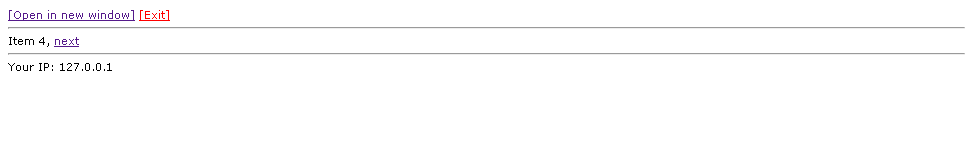

In [123]:
run_webserver_iframeclient_screenshot(app)

Flask может не только парсить URL по маске вида `/item/<int:itemid>`, но и:
* принимать произвольные пути роутом вида `/<path:p>`
* получать метод запроса (GET, POST, ...) `request.method`
* получать GET-параметр из похожего на словарь объекта `request.args`
* получать POST-параметр `request.forms`
* получать файлы аплоада `request.files`
* получать HTTP-заголовки запроса `request.headers`
* устанавливать HTTP-заголовки ответа
```python
return make_response('body', headers={'Header':'value'})
```
* получать куки `request.cookie`
* устанавливать куки (параметры, которые браузер передает при каждом запросе к некоторому хосту или пути, до истечения срока)
```python
resp = make_response(...)
resp.set_cookie('name', 'value')
return resp
```
* возвращать код ошибки `abort(404)`
* возвращать редирект `return redirect(url_for('index'))`

## Вебсокеты

Упоминаются библиотеки `flask_sockets` и `websocket-client`.

У HTTP есть большая проблема — сервер только отвечает на запросы клиентов и не может им что-нибудь сообщить сам, когда возникнет нужда. Для ее решения был изобретен протокол WebSockets, в котором клиент и сервер устанавливают постоянное соединение и отправляют друг другу пакеты, когда вздумается. Все браузеры его поддерживают уже лет 10 https://caniuse.com/#search=websockets

Flask может обрабатывать Websocket-соединения с помощью библиотеки `flask_sockets` и некоторого шаманства с нижележащими библиотеками.

```
pip install flask_sockets
```

С клиентской стороны инициируется соединение, например `ws = new WebSocket('ws://localhost:5001/websocket')`, где по URL через HTTP происходит хэндшейк (трафик затем идет через другой порт). У `ws` устанавливаются коллбэки `.onmessage`, реже `.onopen`, `.onclose` и `.onerror`. Коллбэк `.onmessage` принимает объект события, хранящий в `.data` переданные сервером данные, и может отправлять данные `ws.send(data)`.

In [79]:
CLIENT = '''
<!DOCTYPE html>
<html>
<head>
<style>
html { font: 11px 'tahoma'; }
#log { border: solid 1px gray; height: 200px; overflow: auto; }
</style>
<script>

var ws = new WebSocket('ws://localhost:5001/websocket');
var log = []
ws.onmessage = function(evt) {
    log.push(evt.data);
    update_html();
};

function send_message() {
    ws.send('click');
}

function update_html() {
    var log_html = '';
    for (var i = 0; i < log.length; ++i) {
        log_html += log[i] + '<br>';
    }
    var log_elem = document.getElementById('log');
    log_elem.innerHTML = log_html;
    log_elem.scrollTop = log_elem.scrollHeight;
}
</script>
</head>
<body>
    <button onclick="send_message()">Click</button>
    <div id="log"></div>
</body>
</html>
'''

In [80]:
import random
from flask import Flask
from flask_sockets import Sockets
from gevent import pywsgi
from geventwebsocket import WebSocketError
from geventwebsocket.handler import WebSocketHandler

app = Flask(__name__)
sockets = Sockets(app)

clients = {}
def on_user_enter(ws):
    clients[ws] = random.randint(100000000, 1000000000)

def on_user_exit(ws):
    del clients[ws]

def on_message(ws, message):
    for client in clients:
        msg = 'Client %d clicked on button' % clients[ws]
        client.send(msg)

@sockets.route('/websocket')
def echo_socket(ws):
    on_user_enter(ws)
    try:
        while not ws.closed:
            message = ws.receive()
            if not message is None:
                on_message(ws, message)
    except Exception as e:
        print e
    on_user_exit(ws)

@app.route('/')
def index():
    return CLIENT

In [81]:
THREE_CLIENTS = '''
<table>
<tr>
<td><iframe src="http://127.0.0.1:5001" height="250"></iframe>
<td><iframe src="http://127.0.0.1:5001" height="250"></iframe>
<td><iframe src="http://127.0.0.1:5001" height="250"></iframe>
</tr>
</table>
'''

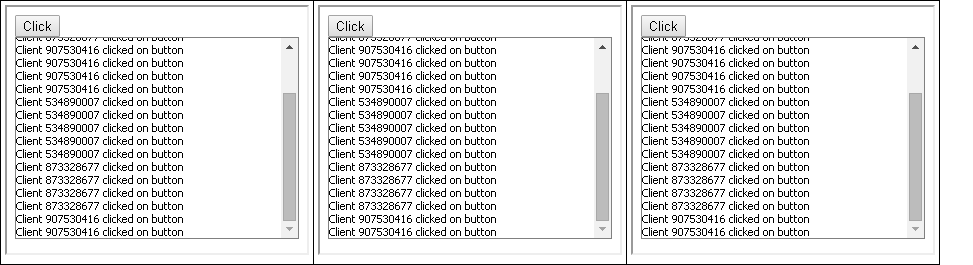

In [82]:
run_webserver_iframeclient_screenshot(app, html=THREE_CLIENTS, with_websockets=True)

Python может выступать не только в роли вебсокет-сервера, но в качестве клиента, благодаря библиотеке `websocket-client`.

```
pip install websocket-client
```

In [44]:
import websocket, sys

In [128]:
print 'Connecting...'; sys.stdout.flush()
ws = websocket.create_connection('wss://echo.websocket.org')
print 'Sending \'Hello, world\'...'; sys.stdout.flush()
ws.send('Hello, world')
print 'Sent'; sys.stdout.flush()
message =  ws.recv()
print 'Received ' + repr(message)
ws.close()

Connecting...
Sending 'Hello, World'...
Sent
Received 'Hello, World'


Библиотека `websocket-client` поддерживает и JavaScript-стиль клиентского объекта.

In [45]:
def on_open(ws):
    ws.send('Hello, world')
def on_message(ws, message):
    print 'Received ' + repr(message)
    ws.close()

ws = websocket.WebSocketApp('wss://echo.websocket.org', on_message=on_message, on_open=on_open)
ws.run_forever()

Received 'Hello, world'


## MJPEG

До появления WebSockets для выдачи клиентам информации, когда сервер захочет, был популярен метод long polling. В ответ на HTTP-запрос сервер не закрывал соединение, а слал и слал новые куски информации, выдерживая паузу. Этот же метод можно применить для достаточно курьезного способа стримить «видео» из бесконечно генерируемых JPEG.

In [38]:
import matplotlib.pyplot, datetime
from io import BytesIO
def draw_cpu_load(ts, load):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(111)
    ax.set_title('CPU Load')
    ax.plot(ts, load)

    ax.set_xlim([ts[-1] - 30, ts[-1]])
    ax.set_ylim([0, None])
    seconds = range(int(ts[-1]) - 30, int(ts[-1]) + 1)
    labels = map(lambda ts: datetime.datetime.fromtimestamp(ts).strftime('%H:%M:%S'), seconds)
    ax.set_xticks(seconds)
    ax.set_xticklabels(labels, rotation='vertical')

    io = BytesIO()
    matplotlib.pyplot.savefig(io, format='jpeg', bbox_inches='tight')
    return io.getvalue()

In [39]:
import time, psutil
def gen():
    ts = []
    load = []
    while True:
        ts.append(time.time())
        load.append(psutil.cpu_percent())
        ts = ts[-60:]
        load = load[-60:]
        jpeg = draw_cpu_load(ts, load)
        yield '--frame\r\nContent-Type: image/jpeg\r\n\r\n' + jpeg + b'\r\n\r\n'
        time.sleep(0.5)

In [40]:
from flask import Flask, Response, url_for

app = Flask(__name__)

@app.route('/')
def index():
    return '<img src="%s">' % url_for('video_feed')

@app.route('/video_feed')
def video_feed():
    return Response(gen(), mimetype='multipart/x-mixed-replace; boundary=frame')

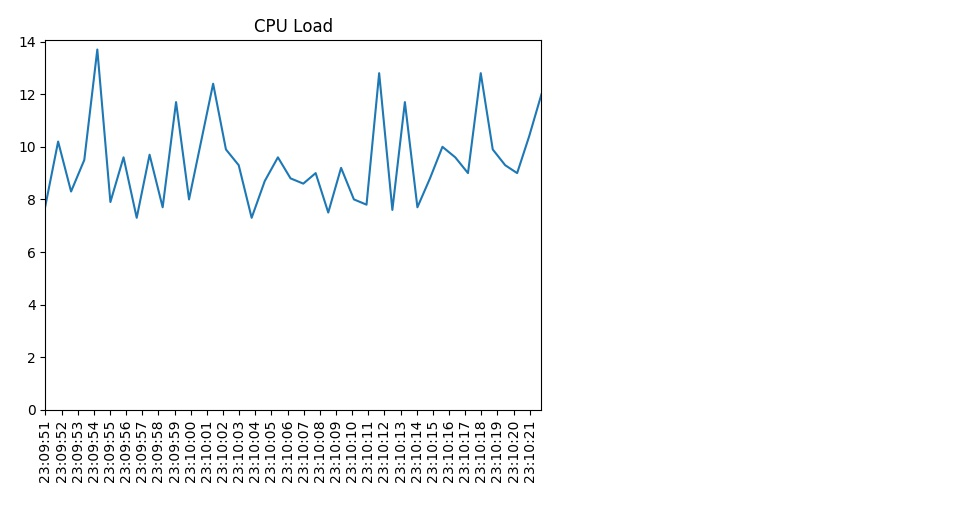

In [41]:
iframe = '<iframe src="http://127.0.0.1:5001/" style="width:100%; height: 500px; border: none;"></iframe>'
run_webserver_iframeclient_screenshot(app, html=iframe)

## Задачи, связанные с вебом

Упоминаются библиотеки `webbrowser`, `mimetypes`, `python-slugify`, `geoip2`, `django-countries`, `socket`

Для того, чтобы сразу после запуска веб-сервера на локальном компьютере показать его пользователю, можно использовать встроенную библиотеку `webbrowser`.

In [28]:
import webbrowser
webbrowser.open('http://127.0.0.1:5555/')
app.run(host='127.0.0.1', port=5555);

В вебе для обозначения формата файла фигурируют MIME types https://www.iana.org/assignments/media-types/media-types.xhtml . Их конвертацию в/из расширения файлов (используя словарь и реестр Windows) осуществляет встроенный модуль `mimetypes`.

In [25]:
import mimetypes
print mimetypes.guess_extension('application/msword')
print mimetypes.guess_extension('text/plain')
print mimetypes.guess_extension('text/html')
print mimetypes.guess_extension('application/json')
print
print mimetypes.guess_type('filename.doc')
print mimetypes.guess_type('filename.doc.gz')
print mimetypes.guess_type('filename.xlsx')
print mimetypes.guess_type('filename.bz2')

.doc
.ksh
.html
None

('application/msword', None)
('application/msword', 'gzip')
('application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', None)
(None, 'bzip2')


ЧПУ (человеко-понятные урлы) получаются из строк, описывающих содержание страницы, слугификацией, транслитерацией и урезанием набора символов до безопасного в Web (буквы, цифры, дефис, знак подчеркивания). Это преобразование осуществляет библиотека `python-slugify`.

```
pip install python-slugify
```

In [6]:
import slugify
print slugify.slugify('Находится ли арктическая панда под угрозой вымирания в 2018?')
print slugify.slugify('中国')

nakhoditsia-li-arkticheskaia-panda-pod-ugrozoi-vymiraniia-v-2018
zhong-guo


Откуда все эти интернет-сайты знают, где вы живете? Компания MaxMind собирает данные о соответствии IP и города, координат, провайдера, VPN ли это или Tor exit node, и торгует ими. Они предоставляют бесплатную и урезанную БД GeoLite2 https://dev.maxmind.com/geoip/geoip2/geolite2/ с оберткой вокруг нее в библиотеке `geoip2`. Теперь и вы можете пробить кого-нибудь по айпишнику!

Показать иконку страны можно, поставив библиотеку `django_countries`. Чтобы заставить ее работать не из Django-приложения, надо сделать немало хаков, к счастью, нам нужны только GIFки.

```
pip install geoip2
Скачать http://geolite.maxmind.com/download/geoip/database/GeoLite2-City.tar.gz
Распаковать из архива GeoLite2-City.mmdb
```

```
pip install django-countries
```

In [100]:
def django_countries_flag_path(iso_code):
    import pkgutil
    flags_path = os.path.join(pkgutil.get_loader('django_countries').filename, 'static/flags')
    return os.path.join(flags_path, iso_code + '.gif')

In [114]:
import geoip2.database, socket, PIL.Image, IPython

HOST = 'www.google.com'
ip = socket.gethostbyname(HOST)
hosts = socket.gethostbyaddr(ip)
reader = geoip2.database.Reader("C:\\Users\\User\\Downloads\\GeoLite2-City.mmdb")
resp = reader.city(ip)

print HOST
print ip
print hosts
print resp.country.iso_code, django_countries.countries.alpha3(resp.country.iso_code), resp.country.names['en']
IPython.display.display(PIL.Image.open(django_countries_flag_path(resp.country.iso_code)))
print resp.subdivisions.most_specific.name
print resp.location.time_zone
print resp.city.name
print resp.location.latitude, resp.location.longitude

www.google.com
172.217.16.68
('ham11s01-in-f4.1e100.net', ['par03s13-in-f68.1e100.net', 'par03s13-in-f68.1e100.net', 'ham11s01-in-f4.1e100.net'], ['172.217.16.68'])
US USA United States


California
America/Los_Angeles
Mountain View
37.4192 -122.0574
